In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from networkx.algorithms import bipartite
from test_and_graphing import community_detection, community_strength
from helper_functions import sum_from_diag, mean_from_diag, calc_from_diag, calc_cutoff_likelihoods, calc_cutoff_index, find_clusters, var_from_diag
from cluster_detection import detect_cluster_structure
from elbow_detection import calc_elbow
from sklearn.cluster import KMeans
from IPython.display import display

In [2]:
def draw_graph(A:np.ndarray, group_labels=None, top_nodes=None):
    pos = None
    G = nx.from_numpy_array(A)
    if top_nodes is not None:
        bottom_nodes = set(G.nodes()) - top_nodes
        nx.set_node_attributes(G, {n: 0 for n in top_nodes}, name='bipartite')
        nx.set_node_attributes(G, {n: 1 for n in bottom_nodes}, name='bipartite')
        pos = nx.bipartite_layout(G, top_nodes)
    else: 
        pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=True, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, edge_color="black")

# graph structure

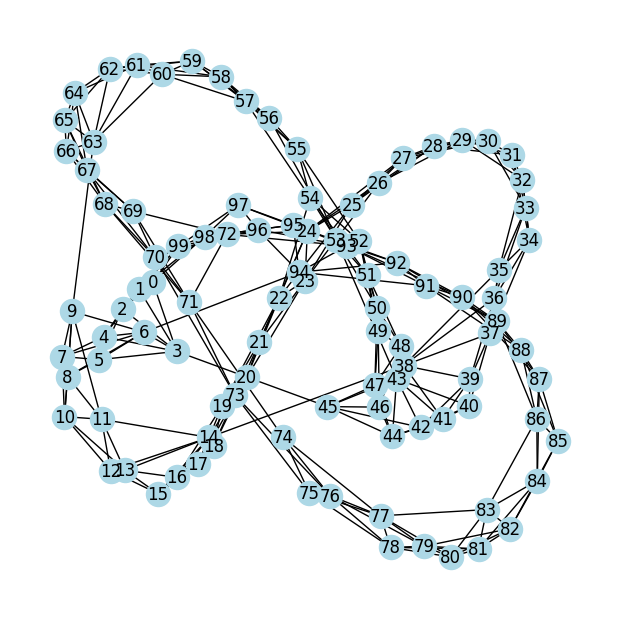

In [3]:
# AL = {
#     0: [1,3],
#     1: [0,2],
#     2: [1,3],
#     3: [0,2,4,6],
#     4: [3,5],
#     5: [4,6],
#     6: [3,5],
# }

# AL = {
#     0: [1,2,3,6],
#     1: [0,2],
#     2: [0,1],
#     3: [4,5,0,6],
#     4: [3,5],
#     5: [3,4],
#     6: [7,8,0,3],
#     7: [6,8],
#     8: [6,7]
# }

# AL = {
#     0: [1,2,3],
#     1: [0,2,3],
#     2: [0,1,3],
#     3: [0,2,4,1],
#     4: [5,7,6,3],
#     5: [4,6,7],
#     6: [5,7,4],
#     7: [4,5,6],
# }

# AL = {
#     0: [1,5],
#     1: [0,2],
#     2: [1,3],
#     3: [2,4],
#     4: [3,5],
#     5: [4,0]
# }

# AL = nx.to_dict_of_lists(nx.davis_southern_women_graph())
# AL = nx.to_dict_of_lists(nx.karate_club_graph())
AL = nx.to_dict_of_lists(nx.watts_strogatz_graph(n=100, k=6, p=0.05))

# top_nodes, bottom_nodes = bipartite.sets(nx.davis_southern_women_graph())

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape
draw_graph(A)

# Doing an SVD decomposition on the |L|= D + A

In [4]:
L_ABS = D + A
U, S, Vt = np.linalg.svd(L_ABS)
V = Vt.T
S = np.diag(S)

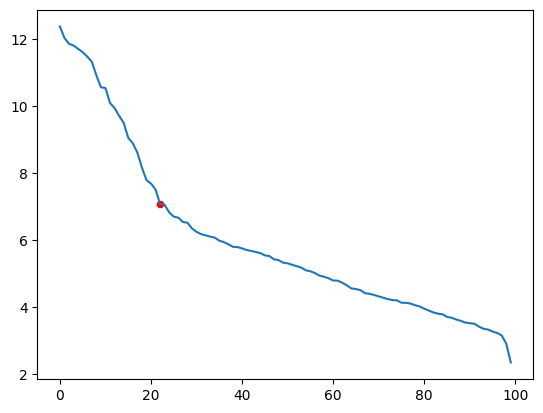

In [5]:
svs = np.diag(S)
# svs_decrease = np.abs(np.diff(svs, prepend=svs[0]))
k = calc_elbow(svs, 0.6)
sns.lineplot(svs)
sns.scatterplot(x=[k], y=[svs[k]], color='red')
# sns.barplot(x=list(range(len(svs_decrease))), y=svs_decrease, color='indigo')
plt.show()

In [6]:
# k = 5
U_k = U[:,0:k+1]
S_k = S[0:k+1,0:k+1]
V_k = V[:,0:k+1]

# Compute cosine matrix

In [7]:
CM = np.zeros((m,n))
vectors = S_k @ V_k.T
for i in range(0,vectors.shape[1]):
    for j in range(i+1, vectors.shape[1]):
        u = vectors[:,i]
        v = vectors[:,j]
        cosine = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
        CM[i,j] = cosine
        CM[j,i] = cosine
np.fill_diagonal(CM, 1)

# Reorder cosine matrix

In [8]:
INDEX = [] # global reordering index
CM_COPY = CM.copy()
indices = list(range(0,CM.shape[1]))
while(len(indices) > 1):
    # sort by cosine similarity
    similarity_list = CM_COPY[0,:]
    new_indices = np.argsort(similarity_list)[::-1]
    
    # rearrange matrix
    indices = [indices[i] for i in new_indices]
    CM_COPY = CM_COPY[np.ix_(new_indices,new_indices)]

    # remove and update
    INDEX.append(indices[0])
    indices.pop(0)
    CM_COPY = CM_COPY[1:,1:]
INDEX.append(indices[0])
del CM_COPY
CM_REORDERED = CM[np.ix_(INDEX, INDEX)]

# this only mismatches the paper's example because vertex 2 is exactly similar to vertex 0 so their ordering doesnt matter

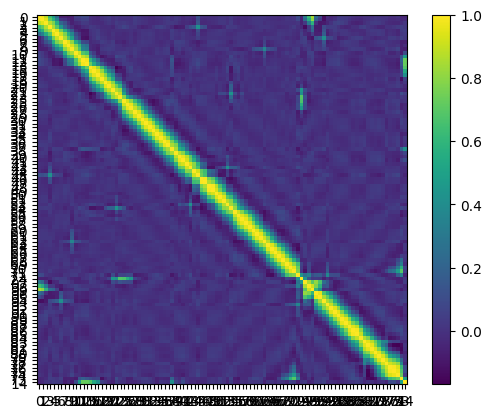

In [9]:
# print(INDEX)
# for r in range(CM_REORDERED.shape[0]):
#     line = ""
#     for c in range(CM_REORDERED.shape[1]):
#         line += str(CM_REORDERED[r,c])
#         if (c < CM_REORDERED.shape[1] - 1):
#             line += ","
#     print(line)

import matplotlib.pyplot as plt

plt.imshow(CM_REORDERED, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show() #17-25

# trying to algorithmically find the clusters

### summing square from the diagonal

[range(0, 5), range(1, 6), range(3, 7), range(4, 9), range(5, 10), range(7, 12), range(8, 14), range(12, 15), range(13, 16), range(14, 20), range(15, 21), range(18, 23), range(20, 24), range(22, 26), range(23, 29), range(25, 31), range(26, 32), range(27, 33), range(28, 34), range(29, 35), range(30, 36), range(32, 37), range(33, 38), range(34, 39), range(35, 40), range(36, 41), range(37, 42), range(38, 43), range(40, 44), range(42, 46), range(44, 49), range(45, 50), range(46, 51), range(47, 52), range(48, 53), range(50, 54), range(51, 55), range(52, 56), range(53, 59), range(54, 60), range(55, 61), range(57, 62), range(58, 63), range(59, 64), range(60, 65), range(61, 66), range(62, 68), range(63, 69), range(65, 70), range(67, 71), range(70, 72), range(71, 73), range(72, 76), range(75, 80), range(76, 81), range(77, 82), range(78, 83), range(79, 85), range(80, 86), range(81, 87), range(82, 88), range(84, 89), range(85, 90), range(86, 91), range(87, 92), range(88, 95), range(91, 97), range

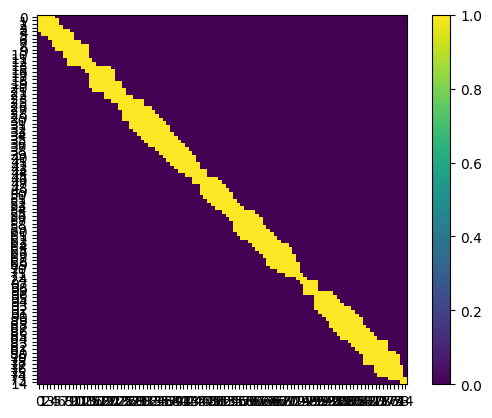

In [10]:
cluster_result = detect_cluster_structure(CM_REORDERED)
print(find_clusters(cluster_result))
plt.imshow(cluster_result, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

/var/folders/wt/rjn2snfs5m9drm826w9lxljw0000gn/T/ipykernel_1446/2252034363.py:3: RuntimeWarning: invalid value encountered in divide
  plt.imshow(M2 / W, cmap='viridis')


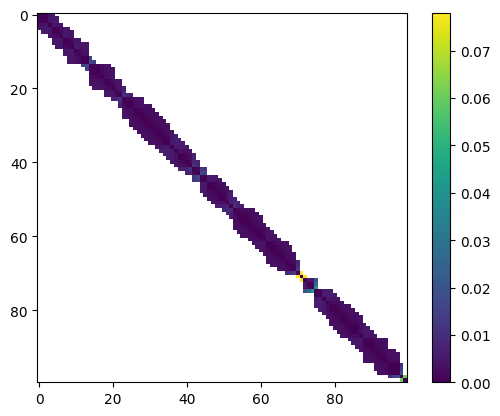

In [11]:
from helper_functions import size_from_diag
(W, M, M2) = detect_cluster_structure(CM_REORDERED, debug=True)
plt.imshow(M2 / W, cmap='viridis')
plt.colorbar()